In [1]:
import sys

import numpy as np

"""
Считываем матрицу из файла
"""

def input_matrix_from_file(f_name):
    matrix = np.loadtxt(f_name)
    n = len(matrix[0])
    m = len(matrix)

    try:
        for i in range(1, m):
            assert len(matrix[i]) == n
    except AssertionError:
        print('Wrong matrix shape')
        sys.exit()

    return matrix

In [2]:
"""
Данная функция находит минимаксный и максиминный элемент
в матрице - седловую точку - и возвращает координаты этой точки.
Если такой точки в матрице нет, функция возвращает кортеж (None, None). 
"""

def saddle_point(a):
    a = np.array(a)
    maximin = np.max(np.min(a, axis=1))
    minimax = np.min(np.max(a, axis=0))

    if minimax == maximin:
        i = np.where(np.min(a, axis=1) == maximin)[0][0]
        j = np.where(np.max(a, axis=0) == minimax)[0][0]

        return i, j
        
    return None, None

In [34]:
from scipy.optimize import linprog

"""
Данная функция решает задачу линейного программирования
с помощью симплекс-метода, который реализован в библиотеке
scipy, методе linprog.
Данный метод решает задачу линейного программирования и возвращает 
объект класса OptimizeResult, в котором хранится значение целевой функции,
вектор оптимальных значений, успешность нахождения результата (OptimizeResult.success)
и другие поля, которые я не задействовал
Так как данный метод умеет решать только задачи поиска нахождения минимума для 
функции с системой A <= b, где А - входная матрица, b - вектор правой части неравенств,
для первого игрока я транспонировал матрицу, домножил ее и вектор правой части на -1
(чтобы получить систему -A <= -b).
Для второго игрока мы решаем задачу максимизации, поэтому я домножил вектор коэффициентов 
целевой функции на -1 => получил задачу минимизации - в конечном результате это я 
учел, домножив полученную целевую функцию на -1
"""

def simplex_method(a):
    a = np.array(a)
    min_el = min(0, np.min(a))
    a += abs(min_el)
        
    second = a
    first = np.copy(np.transpose(second))

    m = len(a)
    n = len(a[0])

    first *= -1
    b_first = np.array([-1] * n)
    c_first = np.array([1] * m)
    b_second = np.array([1] * m)
    c_second = np.array([-1] * n)
    bound = (0, None)

    res_first = linprog(c_first, b_ub=b_first, A_ub=first, bounds=bound, method='simplex')
    res_second = linprog(c_second, b_ub=b_second, A_ub=second, bounds=bound, method='simplex')

    if res_first.success and res_second.success:
        target_f = 1 / res_first.fun
        P = np.array(res_first.x) * target_f
        Q = np.array(res_second.x) * target_f
        target_f -= abs(min_el)

        return target_f, P, Q
    else:
        return None, None, None

In [35]:
"""
Данная функция находит цену игры и оптимальные стратегии первого и второго игроков
и выводит результат на экран
"""

def nash_equilibrium(a):
    a = np.array(a)
    i, j = saddle_point(a)
    if i != None:
        print("There is a solution in pure strategies for both players:")
        print("Optimal strategy for the 1st player: ", end='')
        print([*a[i]])
        print("Optimal strategy for the 2nd player: ", end='')
        print([*a[:, j]])
        print("Game value: {}".format(a[i][j]))
        return a[i][j], a[i], a[:, j]

    try:    
        target_f, p, q = simplex_method(a)

        assert target_f != None
    except AssertionError:
        print("Simplex method didn't succeed to find an optimal solution")
        sys.exit()
    
    print("There is a solution in mixed strategies: ")
    print("Optimal strategy for the 1st player: ", end='')
    print_strategy(p)
    print("Optimal strategy for the 2nd player: ", end='')
    print_strategy(q)
    print("Game value: ", end='')
    print("%.4f" %target_f)

    return target_f, p, q

In [36]:
import matplotlib.pyplot as plt

"""
Данная функция визуализирует спектры оптимальных стратегий 
с помощью библиотеки matplotlib.
"""

def vizualization(p, num):
    plt.title("Визуализация вектора оптимальной стратегии {}-го игрока".format(num))
    x = np.linspace(1, len(p), num=len(p)) 
    plt.axis([0, len(p) + 1, 0, max(p) + 1/2]) 
    plt.style.use('ggplot')
    plt.stem(x, p, basefmt=' ')
    plt.show()

In [37]:
def print_strategy(p):
    print('[', end=' ')
    for s in p:
        print("%.4f" %s, end=' ')
    print(']')

There is a solution in pure strategies for both players:
Optimal strategy for the 1st player: [9.0, 3.0, 3.0, 7.0, 3.0]
Optimal strategy for the 2nd player: [0.0, 3.0, 3.0]
Game value: 3.0

Test Answer:
V = 4
1st : [ 5, 6, 4, 5 ]
2nd : [4, 3, -2]


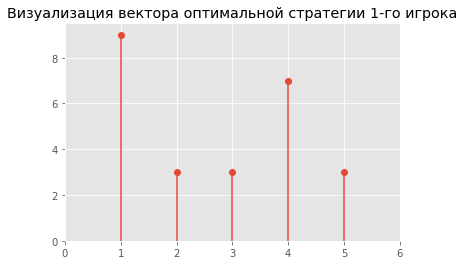

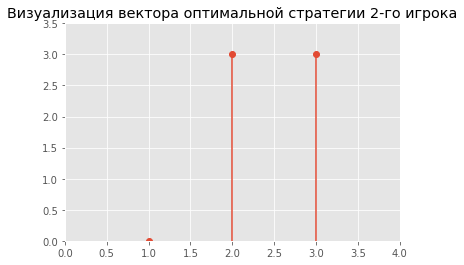

In [43]:
"""
Проведем тестирование результатов работы функции, 
сравнив их с тестовыми играми.
"""
matrix = input_matrix_from_file("test1.txt")

target_f, p, q = nash_equilibrium(matrix)

print()
print("Test Answer:\nV = 4\n1st : [ 9, 3, 3, 7, 3 ]\n2nd : [ 0, 3, 3 ]")

vizualization(p, 1)
vizualization(q, 2)

There is a solution in mixed strategies: 
Optimal strategy for the 1st player: [ 0.0000 0.1290 0.0968 0.4355 0.3387 0.0000 ]
Optimal strategy for the 2nd player: [ 0.0000 0.0000 0.6909 0.1452 0.1478 0.0161 ]
Game value: 4.8710

Test Answer:
V = 4.871
1st : [ 0, 0.129, 0.0968, 0.4355, 0.3387, 0 ]
2nd : [ 0, 0, 0.6909, 0.1452, 0.1478, 0.0161 ]


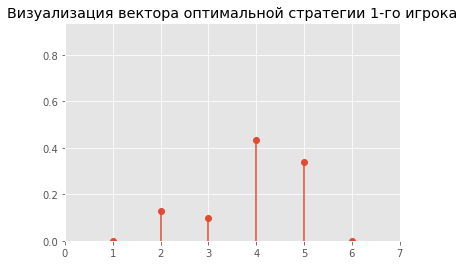

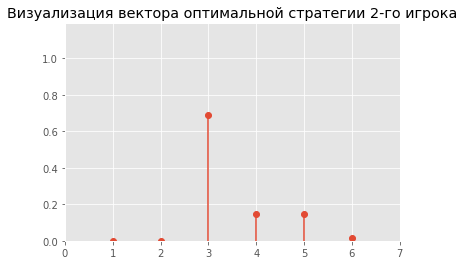

In [46]:
matrix = input_matrix_from_file("test2.txt")

target_f, p, q = nash_equilibrium(matrix)

print()
print("Test Answer:\nV = 4.871\n1st : [ 0, 0.129, 0.0968, 0.4355, 0.3387, 0 ]\n2nd : [ 0, 0, 0.6909, 0.1452, 0.1478, 0.0161 ]")

vizualization(p, 1)
vizualization(q, 2)

There is a solution in mixed strategies: 
Optimal strategy for the 1st player: [ 0.5429 0.1714 0.2857 ]
Optimal strategy for the 2nd player: [ 0.2571 0.4000 0.3429 ]
Game value: 2.5143

Test Answer:
V = 2,5143
1st : [ 0.5429, 0.1714, 0.2857 ]
2nd : [ 0.2571, 0.4, 0,3429 ]


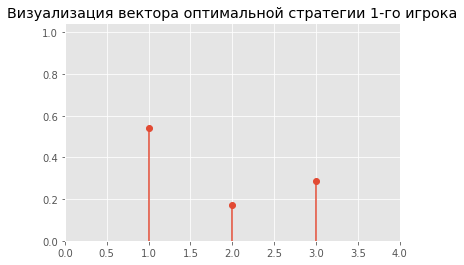

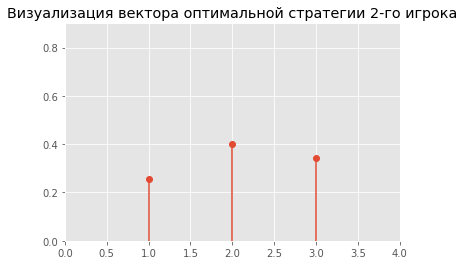

In [47]:
matrix = input_matrix_from_file("test3.txt")

target_f, p, q = nash_equilibrium(matrix)

print()
print("Test Answer:\nV = 2,5143\n1st : [ 0.5429, 0.1714, 0.2857 ]\n2nd : [ 0.2571, 0.4, 0,3429 ]")

vizualization(p, 1)
vizualization(q, 2)